# 6.5 Lab 1: Subset Selection Methods

## 6.5.1 Best Subset Selection

In [34]:
"""This notebook contains the code for best subset selection, 
so this notebook may take longer time to run, for faster run, make
max_feature  into a smaller number"""
max_feature = 3
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import time
import random
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model


In [35]:
Hitters = pd.read_csv('data/Hitters.csv', header=0, na_values='NA')

print list(Hitters) # get the header of this data

print Hitters.shape # get the dimension of this 

Hitters.head() # pull a sample of this dataset

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']
(322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [36]:
print np.sum(pd.isnull(Hitters['Salary'])) # number of NAs in Salary column'
print Hitters['Salary'].isnull().sum()

Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
Hitters.shape

print Hitters['Salary'].isnull().sum()

59
59
0


In [37]:
y = Hitters.Salary  # the response variable 

"""
take care of the features 
1. change category into dummy variables 
2. Choose (n-1) dummy variable into the feature set: n is the unique values of each categorical variable.
"""

dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
print dummies.head()

X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0         0         1           0           1            0            1
1         1         0           0           1            1            0
2         0         1           1           0            0            1
3         0         1           1           0            0            1
4         1         0           0           1            1            0


In [38]:
"""
Since in Python there is no well-defined function for best subset selection, 
we will need to define some functions ourselves.
1. Define a function to run on a subset of feature and extract RSS
2. Select the best model (models) for a fix number of features
"""
def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()
    RSS = ((model.predict(X[list(feature_list)]) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].argmin()] ## this could be modified to have the top several models
    return best_model

In [39]:
models = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models.loc[i] = bestModel(y, X, i)
    
print models.loc[2, 'Model'].summary() 
# this summay confirms that the best two variable model contains the variables Hits and CRBI

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           5.80e-82
Time:                        11:06:09   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

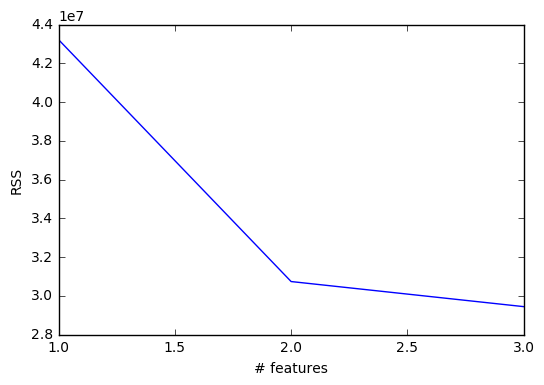

In [40]:
""" this show an example to plot the RSS of best models with different number of parameters"""
plt.figure()
plt.plot(models["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [41]:
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1) # find the adjust R^2, use dir() to identify all available attributes

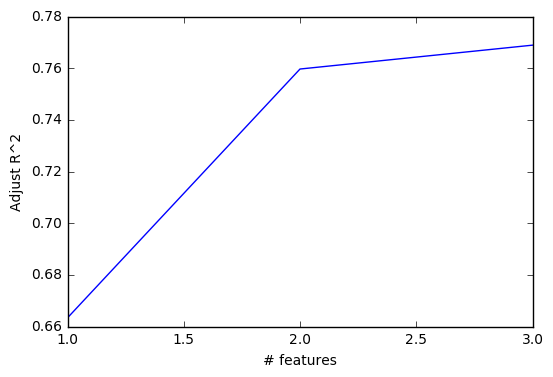

In [42]:
"""
The following graph shows the adj R^2 is still increasing, 
in this case, it is a good idea trying models with more features. 
"""
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('Adjust R^2')
plt.show()

## 6.5.2 Forward and Backward Stepwise Selection

### Forward Stepwise Selection

In [43]:
"""
We can use the previous user defined function 'def getRSS(y, X, feature_list)' to add 1 feature at a time (start from 0 feature) for forward stepwise selection
or delete 1 feature at a time(start from all the features) for backward stepwise selection. 
"""
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model  

In [44]:
models2 = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward_select(y, X, feature_list)
    feature_list = models2.loc[i]["Model"].model.exog_names

In [45]:
"""we can compare the results of best subset selection and the forward selection"""
print('Best max_feature variable from best subset selection on tranining')
print models.loc[max_feature, 'Model'].params
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print models2.loc[max_feature, 'Model'].params

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64


### Backward Stepwise Selection

In [46]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model  

In [47]:
"""
The backward selection starts from all the variables of features
"""
models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)))
feature_list = X.columns

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models3.loc[len(feature_list)-1]["Model"].model.exog_names

print models3.loc[max_feature, "Model"].params

Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64


## 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

### In previous sections, we defined the 'best' model based on some statistics (R^2, adj R^2, AIC, BIC, etc) of the training dataset. This may cause 'overfitting' problemm which means the best model on training data can not generalize well to new data. In this section, validation approach will be discussed.

### Validation Set Approach and best subset selection / Validation Set Approach and forward selection

In [48]:
# Randomly split the data into traning dataset and validation dateset
np.random.seed(seed = 21)
train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3]) 
# random select ~70% of data into traning sample
# the rest of the samples will be in testing set.
test_index = np.invert(train_index)
X_train= X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [49]:
""" We can recyle the old functions. Modification is needed to compute the RSS fpr the testing data. 
So we need to add both train and test into the function input (Implement)
-OR-: we can wrap the train and test split step into the function(Not Implemented)
"""
def getRSS_validation(y_train, X_train, y_test, X_test,  feature_list):
    model = sm.OLS(y_train, X_train[list(feature_list)]).fit()
    RSS = ((model.predict(X_test[list(feature_list)]) - y_test) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel_validation(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].argmin()] ## this could be modified to have the top several models
    return best_model


def forward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model

def backward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test,  combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model  

In [50]:
models_validation= pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models_validation.loc[i] = bestModel_validation(y_train, X_train, y_test, X_test, i) 
    
    
"""change the function to  forward_select_validation (.) or backward_select_validation(.) 
for forward selection or backward selection""" 
    
models2_forward = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2_forward.loc[i] = forward_select_validation(y_train, X_train, y_test, X_test,  feature_list)
    feature_list = models2_forward.loc[i]["Model"].model.exog_names    


In [51]:
print('Best max_feature variable from best subset selection on tranining')
print models.loc[max_feature, 'Model'].params
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print models2.loc[max_feature, 'Model'].params
print('\n---------------------------------------------')
print('Best max_feature variable from backward selection on tranining')
print models3.loc[max_feature, 'Model'].params
print('\n---------------------------------------------')
print('Best max_feature variable from best subset selection on traning and validation split')
print models_validation.loc[max_feature, 'Model'].params

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from backward selection on tranining
Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64

---------------------------------------------
Best max_feature variable from best subset selection on traning and validation split
Hits       2.591880
CHmRun     2.675775
PutOuts    0.210471
dtype: float64


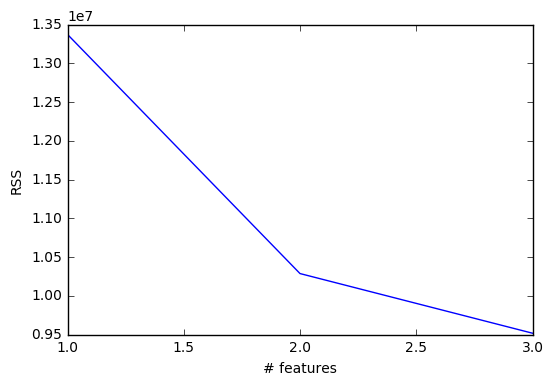

In [52]:
""" this show an example to plot the RSS of best models with different number of parameters for best subset with validation"""
plt.figure()
plt.plot(models_validation["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

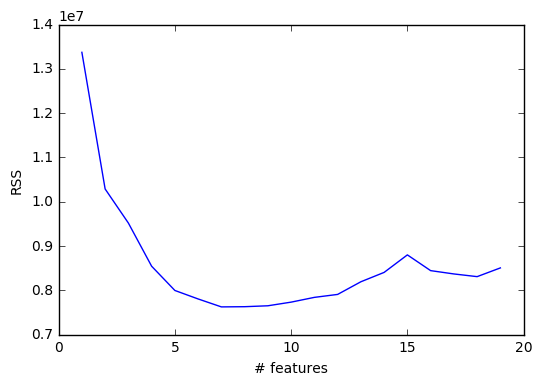

' From above graph, that 6 variables model gives us the best RSS under forward selection. \nTo learn the final model, it is also recommendated to re-train the model on entire data (train + validation). '

In [53]:
""" this show an example to plot the RSS of best models with different number of parameters for forward selection with validation"""
plt.figure()
plt.plot(models2_forward["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()
""" From above graph, that 6 variables model gives us the best RSS under forward selection. 
To learn the final model, it is also recommendated to re-train the model on entire data (train + validation). """

### Cross-Validation

In [79]:
"""This approach is similar to the previous validation idea. 
The difference is that we break the entire dataset into K different folds. 
Each run, the model will be trained on all the data from K-1 folds and tested on the remaining fold.
Advantages: 
1. There will be multiple metrics out of testing results => distribution of testing RSS, etc
2. The size of traning dataset is much closer to the size of original dateset. This will remove some biases caused by
the size difference."""

k = 10
np.random.seed(seed = 21)
train_index = np.random.choice(k, size = len(y), replace = True)  # Randomly assign each observations into folds
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X.columns) + 1))

In [80]:
models_cv = pd.DataFrame(columns=["RSS", "Model"])
for j in range(1,k+1):
    feature_list = []
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward_select_validation(y[train_index!= (j-1)], X[train_index != (j-1)], 
                                                     y[train_index == (j-1)],X[train_index == (j-1)], 
                                                     feature_list)
        
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = models_cv.loc[i]["Model"].model.exog_names

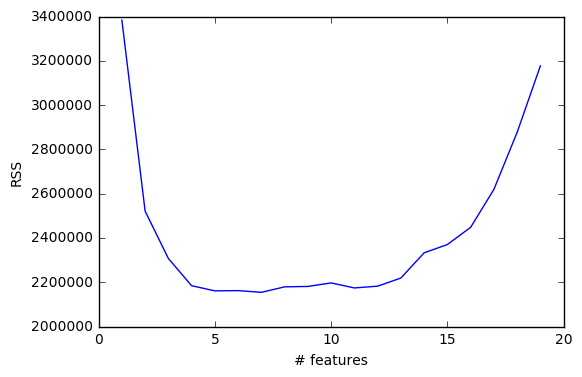

In [82]:
cv_errors_mean = cv_errors.mean(axis = 1)
plt.figure()
plt.plot(cv_errors_mean)
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [85]:
"""From the above plot, we can see that the model with 5 variables yielded the smallest RSS.
We can take a closer look at that model summary. 
We can also see that the model performance for variables 4 - 12 are similar."""
print(models_cv.loc[5, "Model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     155.0
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           1.40e-71
Time:                        11:34:25   Log-Likelihood:                -1704.1
No. Observations:                 235   AIC:                             3418.
Df Residuals:                     230   BIC:                             3435.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Walks          6.3470      0.934      6.795      0.0

# 6.6 Lab 2: Ridge Regression and the Lasso